In [607]:
import pymysql
import pandas as pd
import pandas.io.sql as sql
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Microsoft Yahei'] #用来正常显示中文标签

#plt.rcParams.update({'font.family':'sans-serif','font.sans-serif':['SimHei'],})
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
pd.set_option('precision', 2)

## 从mysql获取已经抓取的数据，关键字 cities／jobs

##### cities = ['全国'] jobs = list(set(['数据分析','数据挖掘','数据产品经理','数据分析师','数据运营','爬虫']))
#### 数据获取： scrapy:daposition
#### 存储地址： mysql:lagou_daposition

In [608]:
# 存到 DF [df0] 中
try:
    conn = pymysql.connect(host='localhost', port=3306, user='root', passwd='111111', db='lagou', charset='utf8')
    df0 = sql.read_sql('select * from daposition', conn)
    conn.close()
except pymysql.Error as e:
    print('Mysql Error %d: %s' %(e.args[0], e.args[1]))

## 数据清理

In [609]:
# 根据positionId 检查数据重复项：False:2034, True 587，有较多重复项，需要清洗
df0.positionId.duplicated().value_counts()

False    2034
True      587
Name: positionId, dtype: int64

In [610]:
# 去重
df0.drop_duplicates(inplace=True)

In [611]:
# 检查数据有无缺失值：各列数据量和样本量一致（district略少，忽略），数据有效
df0.head(1)

,city,district,createTime,salary,companyShortName,positionName,workYear,education,jobNature,industryField,...,companySize,companyFullName,positionLables,industryLables,companyLabelList,financeStage,approve,isSchoolJob,companyId,positionId
0,杭州,西湖区,2017-08-09 09:30:45,8k-16k,蜂融网络,数据运营,3-5年,本科,全职,"移动互联网,金融",...,50-150人,杭州蜂融网络科技有限公司,"['大数据', '数据分析', '数据挖掘', 'R']",['暂无'],"['股票期权', '午餐补助', '专项奖金', '弹性工作']",成长型(A轮),1,0,136800,3069061


In [612]:
df0.head(1)
# 重设 index,确保index有序
df0 = df0.reset_index(drop=True)

In [613]:
#df1.info()
#df0['salary'].unique()

In [614]:
# 手动处理两个salary特殊格式的值
#df0.salary.unique()
#df0[df0.salary=='35k以下']
#df0[df0.salary=='15k以上']
df0.iloc[1623,3] = '15k-25k'
df0.iloc[1973,3] = '0k-35k'

In [615]:
# 拆分salary(8k~16k) 为 salary_high(8) 和 salary_low(16)
df0['salary_low'] = df0['salary'].str.split('k|K',expand=True)[0].astype(int)
df0['salary_high'] = df0['salary'].str.split('k|K',expand=True)[1].str.replace('-','').astype(int)

In [616]:
df0.head(1)

,city,district,createTime,salary,companyShortName,positionName,workYear,education,jobNature,industryField,...,positionLables,industryLables,companyLabelList,financeStage,approve,isSchoolJob,companyId,positionId,salary_low,salary_high
0,杭州,西湖区,2017-08-09 09:30:45,8k-16k,蜂融网络,数据运营,3-5年,本科,全职,"移动互联网,金融",...,"['大数据', '数据分析', '数据挖掘', 'R']",['暂无'],"['股票期权', '午餐补助', '专项奖金', '弹性工作']",成长型(A轮),1,0,136800,3069061,8,16


In [617]:
# 先检查按公司名 的 数量排序，为排除单个公司发布特别的岗位，干扰分析结果
#df0.companyShortName.value_counts()

In [618]:
#df0[df0.companyShortName=='美团点评'].city.value_counts()

In [619]:
# 清理 原始会投资(168) 美团点评(87) 两个样本量超大的公司
# df = df0[(df0.companyShortName !='原始会投资')&(df0.companyShortName !='美团点评')]

In [620]:
# 更改 workYear=='应届毕业生' 为 ‘应届’
df0.loc[df0.workYear=='应届毕业生','workYear'] = '应届'
df0.loc[df0.workYear=='10年以上','workYear'] = '十年+'
df0.loc[df0.workYear=='1年以下','workYear'] = '1-'
# df0[df0.workYear=='应届']

In [621]:
# 删除几列不重要的数据
df1 = df0.drop(['companyId','companyFullName','isSchoolJob','approve','salary'],axis=1).copy()

In [622]:
## 数据清理完毕，开始进行基本分析

### 基本分析 - 全职／兼职； 工作时间要求； 学历要求； 

In [623]:
#df.companyShortName.value_counts()

In [624]:
df1.jobNature.value_counts()
# 几乎所有要求全职

全职    2029
兼职       3
实习       2
Name: jobNature, dtype: int64

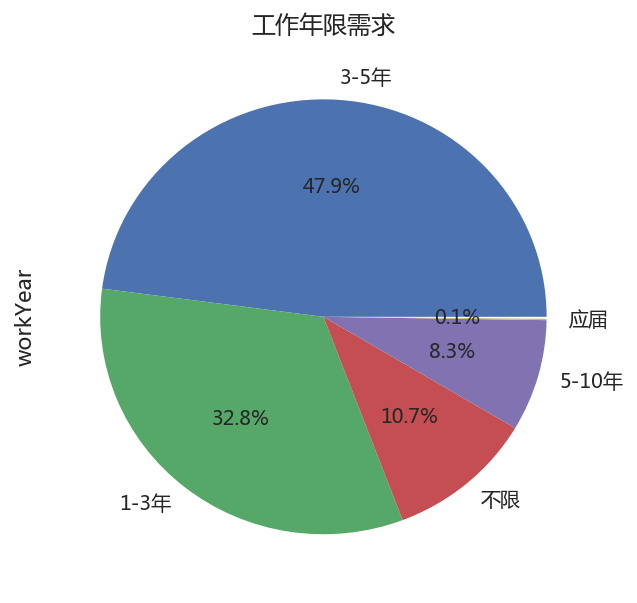

In [625]:
df1.workYear.value_counts(normalize=True)
# 3-5年 及 1-3年 占最多比重
# 3-5年 及 1-3年 占最多比重
df1.workYear.value_counts(normalize=True).head(5).plot(title='工作年限需求', kind='pie', autopct='%1.1f%%', figsize=(5,5))

In [626]:
df1.education.value_counts(normalize=True)
# 本科占80%以上，硕士及以上仅占6%不到

本科    8.11e-01
大专    8.75e-02
硕士    5.46e-02
不限    4.57e-02
博士    9.83e-04
Name: education, dtype: float64

### 数据分析 - 多城市对比

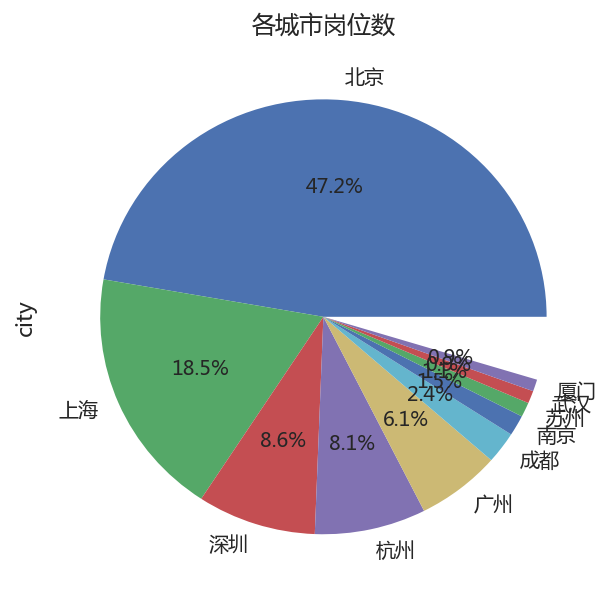

In [627]:
# 查看总的岗位数量在每个城市的分布比例情况
df1.city.value_counts(normalize=True).head()
df1.city.value_counts(normalize=True).head(10).plot(title='各城市岗位数', kind='pie', autopct='%1.1f%%', figsize=(5,5))

In [903]:
# 后续只分析前 7 的城市 (占总职位数的 92.4%)
print(df1.city.value_counts(normalize=True).head(7))
print(df1.city.value_counts(normalize=True).head(7).sum())
maincity = (df1.city =='北京')|(df1.city =='上海')|(df1.city =='深圳')|(df1.city =='杭州')|\
    (df1.city =='广州')|(df1.city =='成都')|(df1.city =='南京')

北京    0.47
上海    0.19
深圳    0.09
杭州    0.08
广州    0.06
成都    0.02
南京    0.02
Name: city, dtype: float64
0.9242871189773844


In [964]:
# 后续只分析 占99.7% 的主要工作年限（'1-3年'／'3-5年'/'1-3年'／'不限'）
print(df1.workYear.value_counts(normalize=True).head(4))
print(df1.workYear.value_counts(normalize=True).head(4).sum())
mainyears = (df1.workYear=='1-3年')|(df1.workYear=='3-5年')|(df1.workYear=='不限')|(df1.workYear=='5-10年')

3-5年     0.48
1-3年     0.33
不限       0.11
5-10年    0.08
Name: workYear, dtype: float64
0.9975417895771879


In [897]:
df_main = df1[maincity & mainyears]

### 数据分析 - 主要城市：工作年限/岗位数；学历／岗位数

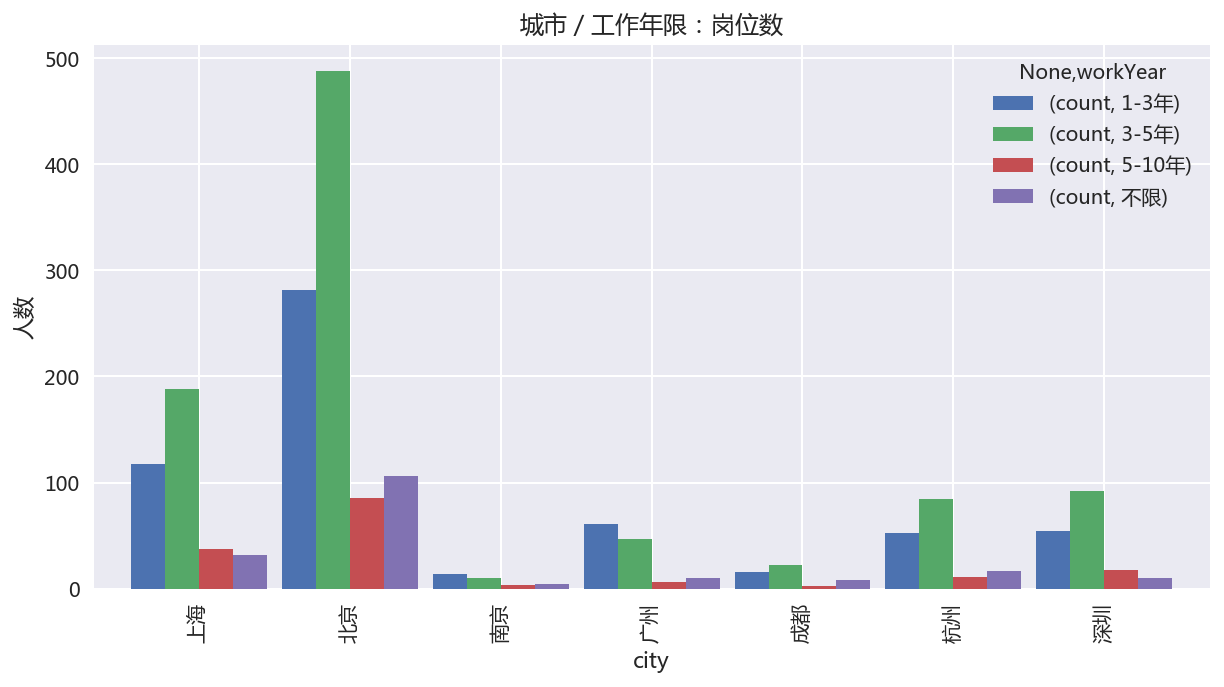

In [966]:
# 城市／工作年限：岗位数
df_main.groupby(['city','workYear']).salary_low.agg(['count']).unstack().fillna('').plot(y=['count'],left = (0),title=('城市／工作年限：岗位数'),kind='bar', width=0.9,figsize=(10,5))
plt.ylabel('人数')

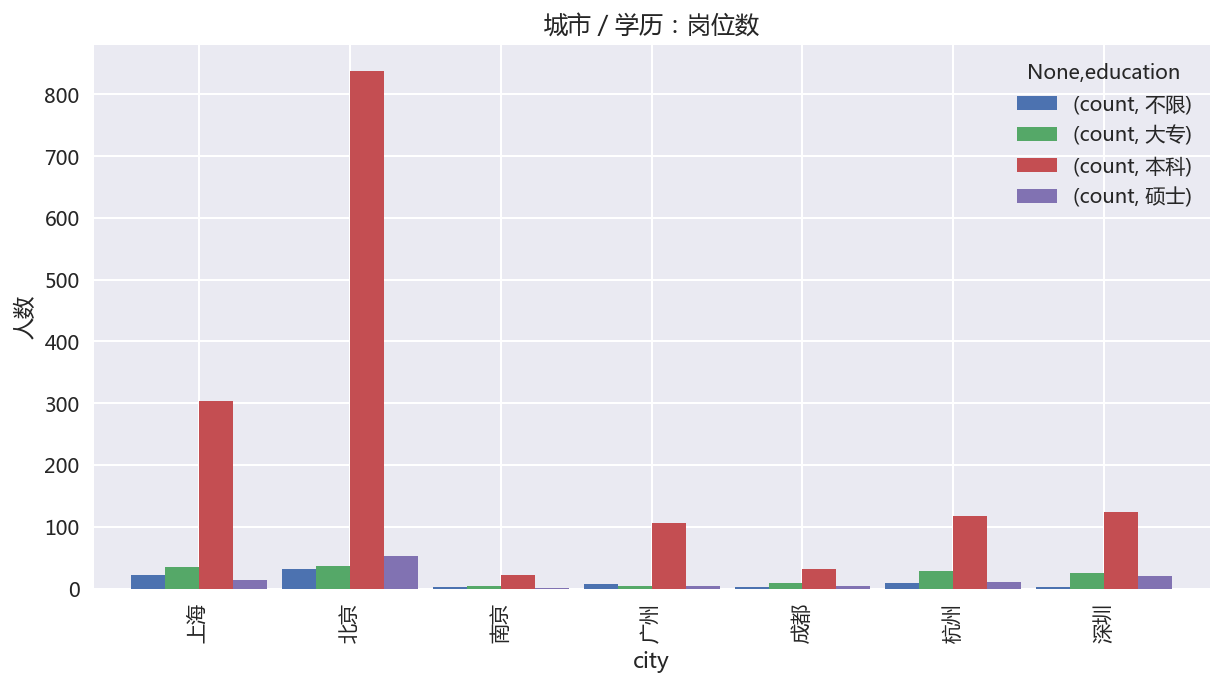

In [965]:
# 城市／学历：岗位数
df_main.groupby(['city','education']).salary_low.agg(['count']).unstack().fillna('').plot(y=['count'],left = (0),title=('城市／学历：岗位数'),kind='bar', width=0.9,figsize=(10,5))
plt.ylabel('人数')

### 数据分析 - 主要城市：工作年限／薪资； 学历／薪资； 

In [962]:
df_main.head(1)

,city,district,createTime,companyShortName,positionName,workYear,education,jobNature,industryField,firstType,secondType,positionAdvantage,companySize,positionLables,industryLables,companyLabelList,financeStage,positionId,salary_low,salary_high
0,杭州,西湖区,2017-08-09 09:30:45,蜂融网络,数据运营,3-5年,本科,全职,"移动互联网,金融",运营/编辑/客服,运营,"发展迅速,全员持股,出国旅游,不打卡",50-150人,"['大数据', '数据分析', '数据挖掘', 'R']",['暂无'],"['股票期权', '午餐补助', '专项奖金', '弹性工作']",成长型(A轮),3069061,8,16


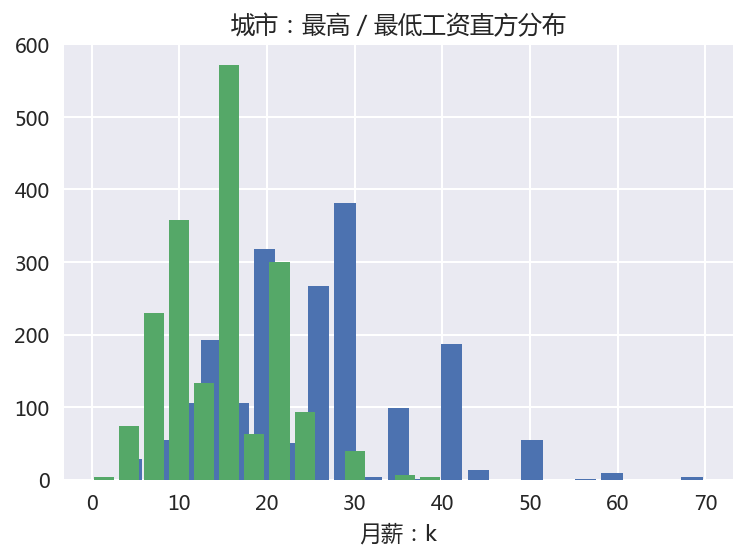

In [1030]:
# 主要城市：最高／最低薪资直方图
plt.hist(df_main['salary_high'],bins=22,rwidth=0.8)
plt.hist(df_main['salary_low'],bins=14,rwidth=0.8)
plt.title('城市：最高／最低工资直方分布')
plt.xlabel('月薪：k')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13caace80>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13cfffe10>], dtype=object)

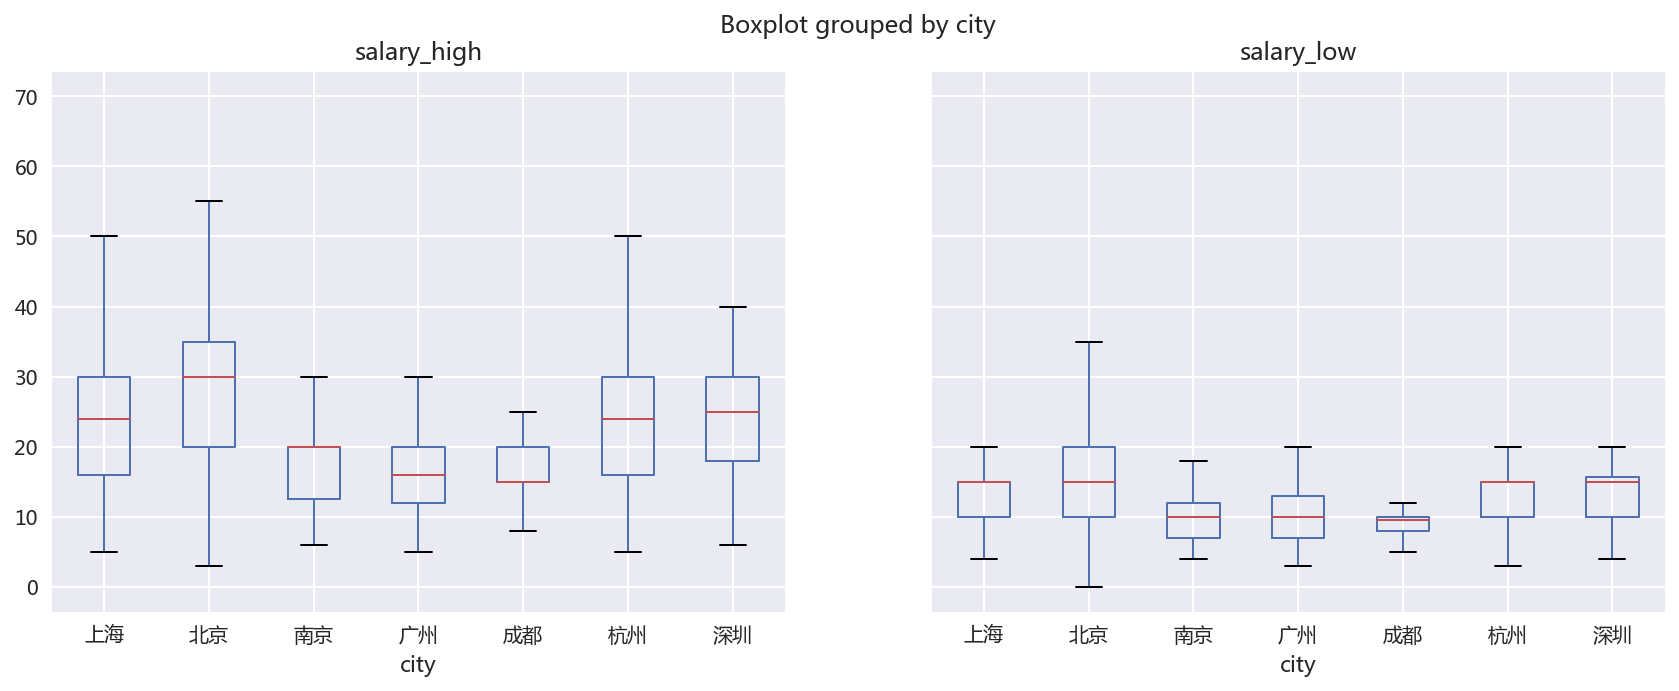

In [1032]:
# 主要城市：最高／最低薪资统计图
df_main.boxplot(column=['salary_high','salary_low'],by=('city'),figsize=(14,5))

In [1029]:
# 各城市分工作年限最高 最低工资的平均
pd.pivot_table(df_main,values=['salary_low','salary_high'], index=['city'], columns=['workYear'],aggfunc=[np.mean]).fillna('')

mean                                                     
         salary_high                      salary_low                     
workYear        1-3年   3-5年  5-10年     不限       1-3年   3-5年  5-10年     不限
city                                                                     
上海             18.03  26.70  33.95  18.09      10.40  15.39  20.68  10.84
北京             22.35  29.80  36.28  25.49      12.56  16.80  21.16  13.76
南京             12.21  21.90  27.67  17.50       7.07  12.20  16.67   9.00
广州             14.89  21.74  25.83  13.20       8.77  12.47  15.83   7.70
成都             14.25  19.23  30.00  13.50       8.25  10.91  15.00   7.62
杭州             17.62  27.11  29.73  15.24       9.83  15.44  17.45   8.76
深圳             19.52  27.20  32.44  20.20      11.11  15.13  18.89  11.00

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d95f320>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13de54940>], dtype=object)

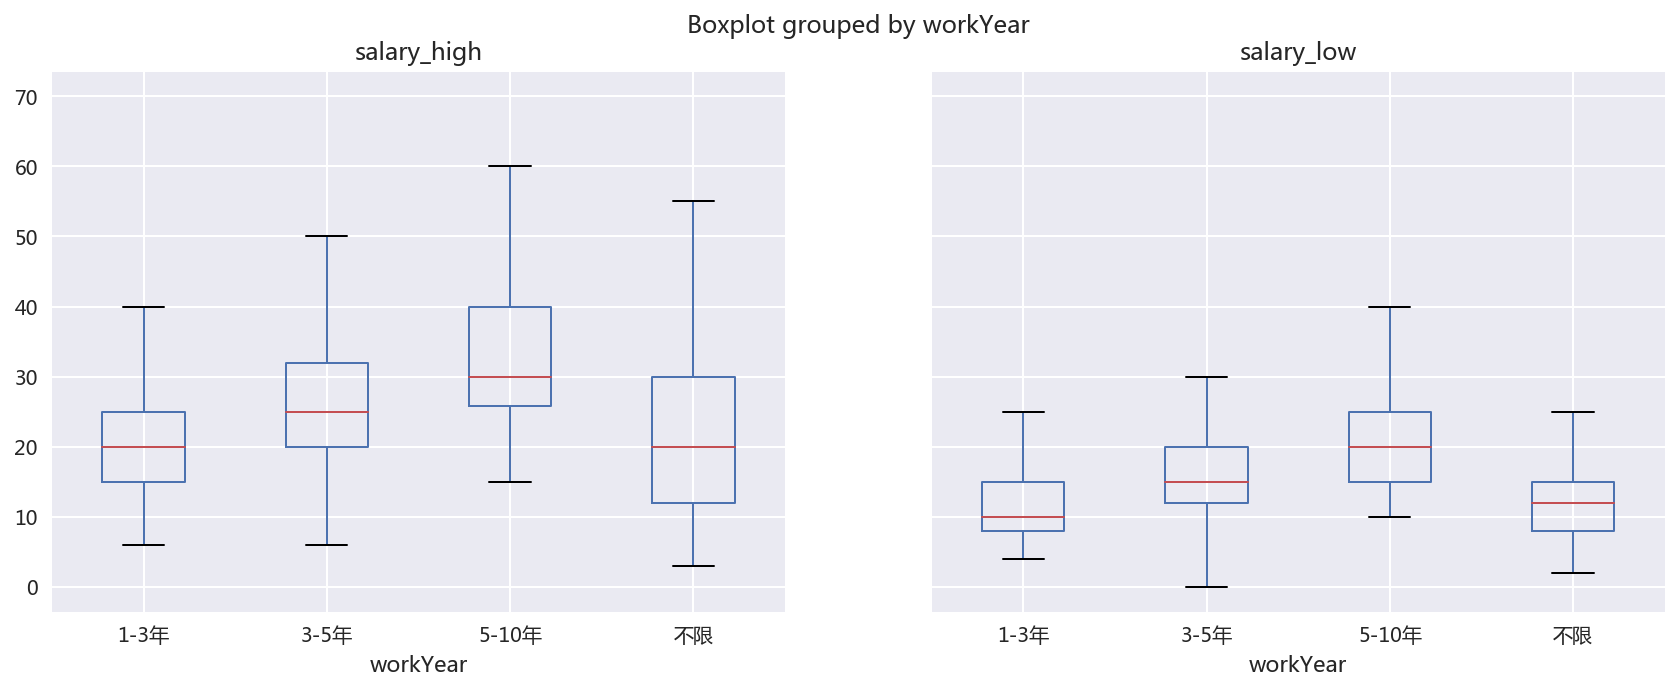

In [1034]:
#df_main.groupby(['city','workYear']).salary_low.count().unstack()
df_main.boxplot(column=['salary_high','salary_low'],by=('workYear'),figsize=(14,5))

In [907]:
# 各城市分学历最高 最低工资的平均
pd.pivot_table(df_main,values=['salary_low','salary_high'], index=['city'], columns=['education'],aggfunc=[np.mean]).fillna('')

mean                                                        \
          salary_high                          salary_low                     
education          不限  博士     大专     本科     硕士         不限  博士     大专     本科   
city                                                                          
上海              21.41      16.94  24.83  26.93      13.23      10.20  14.42   
北京              26.72      21.43  27.77  31.85      15.28      12.54  15.59   
南京              16.67      15.20  18.59   8.00      10.67       9.00  10.18   
广州              14.88      12.80  18.34  18.00       8.88       7.80  10.68   
成都              15.33      14.22  17.78  19.00       8.33       8.67  10.03   
杭州              21.00      18.32  23.58  31.80      12.11      10.57  13.32   
深圳              23.33  40  18.52  24.80  32.70      11.67  22  11.68  13.90   

                  
                  
education     硕士  
city              
上海         14.64  
北京         18.26  
南京          6.00  
广州         10.20  
成都          9.75  
杭州         18.50  
深圳         17.30

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d9919e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x13ecfc550>], dtype=object)

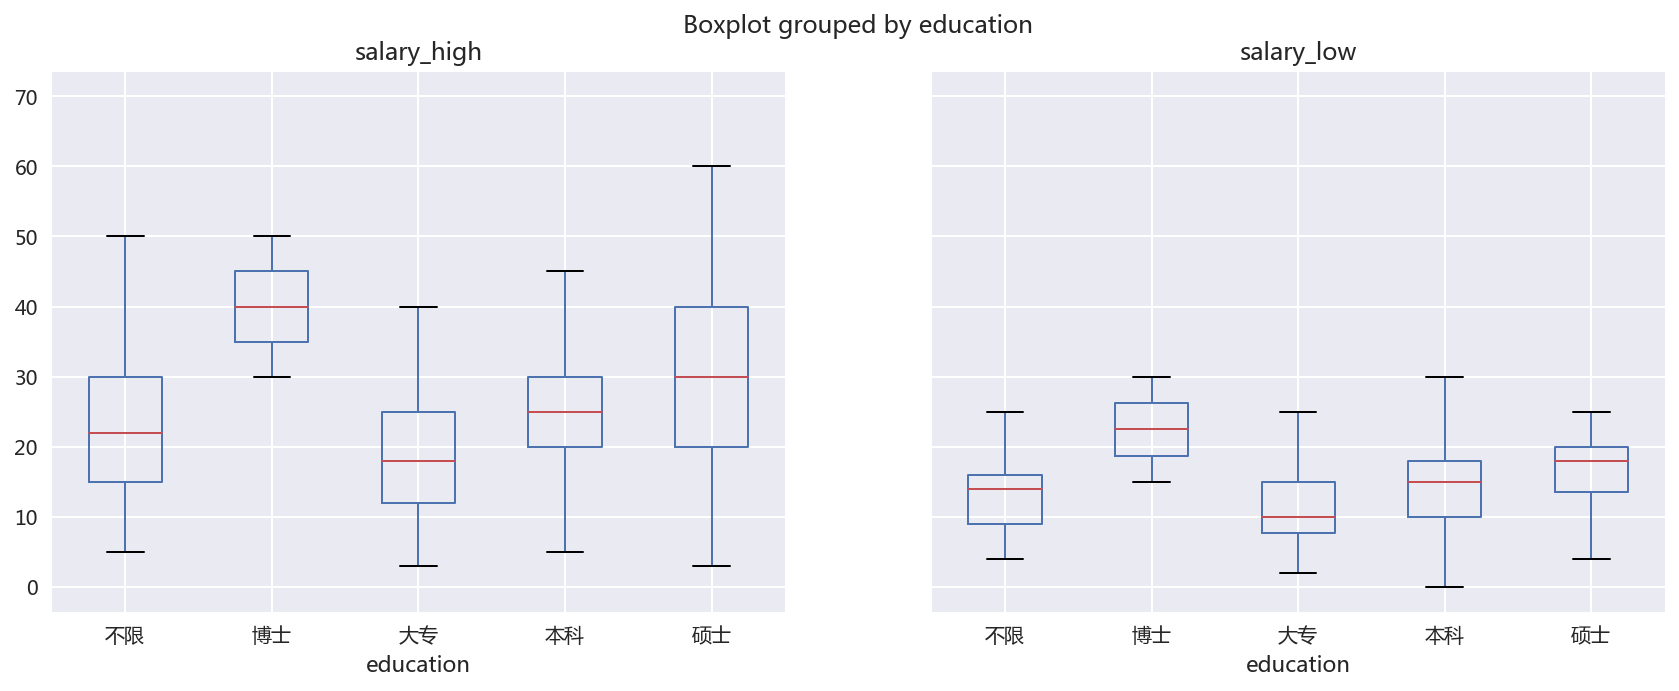

In [1036]:
df_main.boxplot(column=['salary_high','salary_low'],by=('education'),figsize=(14,5))

In [ ]:
### 数据分析 - 各城市：主要公司／岗位数

In [1064]:
# 数据分析 - 各城市：主要公司／岗位数（按总的排行）
df_main.groupby(['city','companyShortName']).city.agg(['count']).sort_values('count',ascending=False).head(20)

count
city companyShortName       
北京   美团点评                 55
     阿里巴巴—高德              25
     原始会投资                22
上海   饿了么                  20
北京   百度                   18
     百度外卖                 17
     今日头条                 16
上海   美团点评                 16
北京   滴滴出行                 14
     去哪儿网                 14
上海   返利网                  14
北京   链家网                  14
     汽车之家                 13
     好未来                  12
     360                  12
杭州   浙江执御信息技术有限公司         12
北京   搜狗                   11
     爱奇艺                  11
     宜信                    9
     小米                    9

In [1063]:
# 数据分析 - 各城市：主要公司／岗位数（按每个城市top5）
def topN(df,n=5):
    counts = df.value_counts()
    return counts.sort_values(ascending=False)[:n]
df_main.groupby('city').companyShortName.apply(topN)

city              
上海    饿了么             20
      美团点评            16
      返利网             14
      链家上海研发中心         9
      驴妈妈旅游网           9
北京    美团点评            55
      阿里巴巴—高德         25
      原始会投资           22
      百度              18
      百度外卖            17
南京    通联数据             4
      南京领添             3
      南京悦才信息科技有限公司     3
      买单侠              3
      网谱数据             2
广州    酷狗音乐             6
      方欣科技             5
      阿里巴巴移动事业群-UC     5
      舜飞科技             5
      Ways             4
成都    tap4fun          3
      四川汽车票务网          2
      聚美优品             2
      NEXA             2
      数联易康科技           2
杭州    浙江执御信息技术有限公司    12
      传化物流集团           5
      铭师堂              5
      分期管家             5
      火石创造             5
深圳    极光               9
      无秘               5
      环球易购             5
      腾讯               5
      投哪网              5
Name: companyShortName, dtype: int64

In [1065]:
# 不同城市 需求前5位的岗位名及岗位数量
df_main.groupby(['city','positionName']).city.agg(['count']).sort_values('count',ascending=False).head(10)

count
city positionName       
北京   数据分析师           109
     数据产品经理           97
     数据挖掘工程师          86
上海   数据分析师            43
北京   爬虫工程师            41
上海   数据挖掘工程师          41
北京   数据运营             34
     数据挖掘             31
     数据分析             30
上海   数据运营             25

In [47]:
# 查看每个城市的 ‘爬虫‘ 岗位分布比例情况
df[df.positionName.str.contains('爬虫')].city.value_counts()

北京     127
上海      54
深圳      40
杭州      31
广州      27
成都      15
南京      13
武汉       9
厦门       5
长沙       3
天津       3
西安       2
宁波       2
重庆       2
青岛       1
合肥       1
佛山       1
烟台       1
石家庄      1
苏州       1
Name: city, dtype: int64

In [49]:
# 查看每个城市的 ‘数据分析‘ 岗位分布比例情况
df[df.positionName.str.contains('数据分析')].city.value_counts()

北京    224
上海    110
杭州     41
深圳     34
广州     31
南京     10
成都      9
厦门      7
福州      6
重庆      6
合肥      6
苏州      4
长沙      3
武汉      3
珠海      3
贵阳      2
天津      2
邯郸      1
嘉兴      1
金华      1
佛山      1
西安      1
温州      1
宁波      1
太原      1
肇庆      1
Name: city, dtype: int64

In [1091]:
dfcd = df_main[df_main.city =='成都']
dfcd.positionName.str.contains('数据分析').value_counts()
print(dfcd[dfcd.positionName.str.contains('数据分析')].city.count())
dfcd[dfcd.positionName.str.contains('数据分析')].sort_values(by='companyShortName')

9


,city,district,createTime,companyShortName,positionName,workYear,education,jobNature,industryField,firstType,secondType,positionAdvantage,companySize,positionLables,industryLables,companyLabelList,financeStage,positionId,salary_low,salary_high
678,成都,锦江区,2017-08-10 14:45:31,Mokitech,数据分析师,不限,本科,全职,游戏,设计,数据分析,福利多多,150-500人,['暂无'],['暂无'],"['技能培训', '节日礼物', '带薪年假', '岗位晋升']",成长型(不需要融资),1872662,8,15
511,成都,锦江区,2017-08-10 09:02:48,NEXA,数据分析师-Data Analyst,不限,本科,全职,"移动互联网,游戏",产品/需求/项目类,数据分析,带薪年假，通讯补贴，五险一金,150-500人,['暂无'],['暂无'],"['年底双薪', '节日礼物', '技能培训', '绩效奖金']",成长型(不需要融资),2610548,8,15
665,成都,高新区,2017-08-10 10:08:18,tap4fun,游戏运营专员-数据分析方向,不限,本科,全职,"移动互联网,游戏",产品/需求/项目类,数据分析,"6险一金,弹性工作制,员工福利",150-500人,['游戏'],['游戏'],"['技能培训', '节日礼物', '年底双薪', '带薪年假']",成长型(不需要融资),2851395,7,12
741,成都,高新区,2017-08-10 16:06:29,初唐科技,数据分析工程师,3-5年,本科,全职,移动互联网,开发/测试/运维类,数据开发,"社保公积金,快速发展,福利多多,周末双休",50-150人,"['广告营销', '数据挖掘', '算法', '机器学习']","['广告营销', '数据挖掘', '算法', '机器学习']","['周末双休', '五险一金', '年底双薪', '午餐补助']",上市公司,3321763,15,25
641,成都,高新区,2017-08-10 18:07:58,成都里森纳科技有限公司,大数据分析师,1-3年,本科,全职,"移动互联网,O2O",开发/测试/运维类,数据开发,"六险一金,周末双休,带薪年假,氛围宽松",15-50人,"['银行', '旅游', '可视化', '建模']","['银行', '旅游', '可视化', '建模']","['节日礼物', '技能培训', '带薪年假', '绩效奖金']",初创型(不需要融资),2998256,6,12
628,成都,高新区,2017-08-10 10:10:15,聚美优品,数据分析,1-3年,本科,全职,电子商务,金融类,风控,"五险一金,绩效奖金",2000人以上,"['金融', '经理', '行业研究', 'SPSS', 'sas']","['金融', '经理', '行业研究', 'SPSS', 'sas']","['技能培训', '节日礼物', '季度奖金', '岗位晋升']",上市公司,3347584,10,20
662,成都,高新区,2017-08-10 10:10:16,聚美优品,风控-数据分析岗,3-5年,本科,全职,电子商务,金融类,风控,五险一金,2000人以上,"['金融', '行业研究', '策略设计', 'SPSS', 'sas']","['金融', '行业研究', '策略设计', 'SPSS', 'sas']","['技能培训', '节日礼物', '季度奖金', '岗位晋升']",上市公司,3371293,10,20
61,成都,武侯区,2017-08-11 09:42:53,重庆鸿巨网络科技有限公司,数据运营经理/高级数据分析师,3-5年,本科,全职,"移动互联网,电子商务",运营/编辑/客服,运营,"工作授权,行业高成长,团队靠谱,工作好玩",150-500人,"['渠道', '电子商务', '用户研究']",['暂无'],"['节日礼物', '带薪年假', '领导好', '帅哥多']",成长型(不需要融资),2964755,8,15
313,成都,武侯区,2017-08-10 13:54:53,顶呱呱,数据分析师,3-5年,大专,全职,金融,产品/需求/项目类,数据分析,"双休,工作餐,平台大,发展空间",2000人以上,"['商业', '业务运营', 'SPSS', 'sas']",['暂无'],"['技能培训', '带薪年假', '绩效奖金', '岗位晋升']",上市公司,3438563,6,8


In [1092]:
print(dfcd[dfcd.positionName.str.contains('数据挖掘')].city.count())
dfcd[dfcd.positionName.str.contains('数据挖掘')].sort_values(by='companyShortName')

9


,city,district,createTime,companyShortName,positionName,workYear,education,jobNature,industryField,firstType,secondType,positionAdvantage,companySize,positionLables,industryLables,companyLabelList,financeStage,positionId,salary_low,salary_high
1719,成都,锦江区,2017-08-10 09:02:49,NEXA,数据挖掘工程师,不限,本科,全职,"移动互联网,游戏",产品/需求/项目类,数据分析,"平台好,环境好",150-500人,"['大数据', '大数据']",['暂无'],"['年底双薪', '节日礼物', '技能培训', '绩效奖金']",成长型(不需要融资),2762482,10,15
1609,成都,高新区,2017-08-10 10:08:18,tap4fun,数据挖掘师,1-3年,本科,全职,"移动互联网,游戏",开发/测试/运维类,数据开发,"薪资福利,绩效奖金,团队氛围,六险一金",150-500人,"['游戏', '广告营销', '数据分析', 'SPSS']","['游戏', '广告营销', '数据分析', 'SPSS']","['技能培训', '节日礼物', '年底双薪', '带薪年假']",成长型(不需要融资),3218184,10,20
1684,成都,高新区,2017-08-10 10:08:18,tap4fun,资深数据挖掘师,3-5年,本科,全职,"移动互联网,游戏",开发/测试/运维类,数据开发,"六险一金,绩效奖金,发展空间大",150-500人,"['广告营销', '数据分析', 'SPSS']","['广告营销', '数据分析', 'SPSS']","['技能培训', '节日礼物', '年底双薪', '带薪年假']",成长型(不需要融资),3351924,15,25
1788,成都,锦江区,2017-08-10 09:21:23,久远银海,数据挖掘工程师,1-3年,本科,全职,"移动互联网,硬件",技术,后端开发,五险一金 年终奖金 带薪年假 节日福利,500-2000人,['暂无'],['暂无'],"['节日礼物', '专项奖金', '带薪年假', '岗位晋升']",上市公司,2417856,5,10
1944,成都,武侯区,2017-08-07 12:33:41,京东商城,中/高级数据挖掘工程师岗,3-5年,本科,全职,电子商务,开发/测试/运维类,数据开发,"发展空间大,大平台,牛人比肩,餐补",2000人以上,"['中级', '数据分析', 'BI', '数据开发']",['暂无'],"['绩效奖金', '午餐补助', '节日礼物', '免费班车']",上市公司,3447994,15,30
1595,成都,高新区,2017-08-10 10:06:50,启发分期,数据挖掘工程师,1-3年,本科,全职,"移动互联网,旅游",开发/测试/运维类,数据开发,"五险一金,股票期权,弹性工作",50-150人,"['金融', '大数据']","['金融', '大数据']","['股票期权', '扁平管理', '互联网金融', '年底双薪']",成长型(不需要融资),2791698,8,16
1804,成都,高新区,2017-08-09 16:26:52,咪咕,数据挖掘工程师,5-10年,本科,全职,"移动互联网,文化娱乐",开发/测试/运维类,数据开发,"大数据平台,发展平台,技术氛围,福利待遇",500-2000人,"['广告营销', '大数据', '算法', '机器学习']","['广告营销', '大数据', '算法', '机器学习']","['定期体检', '带薪年假', '绩效奖金', '专项奖金']",成熟型(不需要融资),3442864,15,30
1629,成都,高新区,2017-08-11 09:14:23,数联易康科技,数据挖掘工程师,3-5年,本科,全职,"数据服务,医疗健康",开发/测试/运维类,数据开发,"数据建模,算法设计",50-150人,"['医疗健康', '大数据', '算法', '机器学习']","['医疗健康', '大数据', '算法', '机器学习']",['暂无'],成长型(A轮),3338208,10,15
1709,成都,高新区,2017-08-11 09:14:23,数联易康科技,数据挖掘,1-3年,硕士,全职,"数据服务,医疗健康",技术,数据开发,发展前景好,50-150人,['暂无'],['暂无'],['暂无'],成长型(A轮),1500588,7,13


In [1101]:
dfcd.loc[dfcd.salary_low > 10,:].sort_values(by='salary_high',ascending=False)

,city,district,createTime,companyShortName,positionName,workYear,education,jobNature,industryField,firstType,secondType,positionAdvantage,companySize,positionLables,industryLables,companyLabelList,financeStage,positionId,salary_low,salary_high
1457,成都,高新区,2017-08-09 09:42:54,BBD,（大数据）产品经理,3-5年,硕士,全职,"电子商务,数据服务",产品/需求/项目类,产品设计/需求分析,"五险一金,节日福利,加班补贴",150-500人,"['金融', '数据分析', '数据挖掘']","['金融', '数据分析', '数据挖掘']","['带薪年假', '绩效奖金', '扁平管理', '定期体检']",成长型(B轮),2720852,20,40
1265,成都,高新区,2017-08-09 16:26:51,咪咕,大数据局产品经理,5-10年,本科,全职,"移动互联网,文化娱乐",产品/需求/项目类,产品设计/需求分析,"互联网,大数据,发展平台,福利待遇",500-2000人,['暂无'],['暂无'],"['定期体检', '带薪年假', '绩效奖金', '专项奖金']",成熟型(不需要融资),3442794,15,30
1804,成都,高新区,2017-08-09 16:26:52,咪咕,数据挖掘工程师,5-10年,本科,全职,"移动互联网,文化娱乐",开发/测试/运维类,数据开发,"大数据平台,发展平台,技术氛围,福利待遇",500-2000人,"['广告营销', '大数据', '算法', '机器学习']","['广告营销', '大数据', '算法', '机器学习']","['定期体检', '带薪年假', '绩效奖金', '专项奖金']",成熟型(不需要融资),3442864,15,30
1944,成都,武侯区,2017-08-07 12:33:41,京东商城,中/高级数据挖掘工程师岗,3-5年,本科,全职,电子商务,开发/测试/运维类,数据开发,"发展空间大,大平台,牛人比肩,餐补",2000人以上,"['中级', '数据分析', 'BI', '数据开发']",['暂无'],"['绩效奖金', '午餐补助', '节日礼物', '免费班车']",上市公司,3447994,15,30
741,成都,高新区,2017-08-10 16:06:29,初唐科技,数据分析工程师,3-5年,本科,全职,移动互联网,开发/测试/运维类,数据开发,"社保公积金,快速发展,福利多多,周末双休",50-150人,"['广告营销', '数据挖掘', '算法', '机器学习']","['广告营销', '数据挖掘', '算法', '机器学习']","['周末双休', '五险一金', '年底双薪', '午餐补助']",上市公司,3321763,15,25
917,成都,锦江区,2017-07-11 10:03:13,同程旅游,爬虫工程师（成都）,3-5年,本科,全职,"旅游,电子商务",开发/测试/运维类,后端开发,D+轮公司、行业Top、购房贷款,2000人以上,"['专家', '资深', '高级', 'Python', '大数据']",['暂无'],"['绩效奖金', '股票期权', '年底双薪', '五险一金']",成熟型(D轮及以上),3227800,15,25
1684,成都,高新区,2017-08-10 10:08:18,tap4fun,资深数据挖掘师,3-5年,本科,全职,"移动互联网,游戏",开发/测试/运维类,数据开发,"六险一金,绩效奖金,发展空间大",150-500人,"['广告营销', '数据分析', 'SPSS']","['广告营销', '数据分析', 'SPSS']","['技能培训', '节日礼物', '年底双薪', '带薪年假']",成长型(不需要融资),3351924,15,25
16,成都,武侯区,2017-08-10 19:06:46,世纪阳天,数据运营,3-5年,本科,全职,"移动互联网,游戏",运营/编辑/客服,运营,"员工餐厅,健身房,游泳池",150-500人,"['大数据', '数据分析', '数据挖掘', '用户研究']",['暂无'],"['带薪年假', '年底双薪', '专项奖金', '帅哥多']",成长型(不需要融资),3398593,15,20
1495,成都,高新区,2017-08-10 18:27:25,知道创宇,高级大数据产品经理,不限,本科,全职,信息安全,产品/需求/项目类,产品设计/需求分析,"技术氛围好,福利待遇优,发展空间大",150-500人,['暂无'],['暂无'],"['节日礼物', '岗位晋升', '美女多', '领导好']",成熟型(C轮),3217814,12,20
1402,成都,高新区,2017-08-11 09:35:21,东方闻道,大数据产品经理,3-5年,本科,全职,"移动互联网,教育",产品/需求/项目类,产品设计/需求分析,"餐饮补贴,年度体检,五险一金,年功金",150-500人,"['教育', '数据分析', '数据挖掘']","['教育', '数据分析', '数据挖掘']","['技能培训', '节日礼物', '带薪年假', '绩效奖金']",成长型(不需要融资),3257870,12,18
